In [1]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from numba import njit
from matplotlib.patches import Ellipse
import torch
import torch.optim as optim
from math import sqrt

In [2]:
def compute_self_energy_gradients(sigmas, volumes, K=1, nu=1, mu=-1):
    d = sigmas.shape[-1]
    volumes_2 = volumes*volumes
    determinants = np.linalg.det(sigmas)
    inverses = np.linalg.inv(sigmas)
    trace_inverses = np.trace(inverses, axis1=-2, axis2=-1)
    c_2 = 1.0/(((2*np.pi)**(d/2))*(2**(d/2))*(np.sqrt(determinants)))
    c_4 = 1.0/(((2*np.pi)**(3*d/2))*(2**(3*d/2))*(determinants**(3.0/2.0)))
    E_V_grads = ((K/2)*trace_inverses*c_2 + nu*volumes_2*c_4 + mu*c_2)*volumes
    E_sigma_grads = (-volumes_2[:,None,None]/4)*(((3*nu/2)*(c_4*volumes_2)[:,None,None] + mu*c_2[:,None,None])*inverses + K*c_2[:,None,None]*( inverses @ inverses + 0.5*trace_inverses[:,None,None]*inverses) )
    return E_sigma_grads, E_V_grads

In [34]:
N = 5
sigmas = np.repeat(np.eye(2)[None,:,:], N, axis=0)
volumes = np.ones(N)
avg_vol = []
avg_sigma2 = []
dt = 0.01
for step in range(1000000):
    sigma_grads, volume_grads = compute_self_energy_gradients(sigmas, volumes,K=1, nu=1.0, mu=-1.)
    sigmas -= dt*sigma_grads
    #volumes -= dt*volume_grads
    avg_vol.append(volumes.mean())
    avg_sigma2.append(sigmas[:,0,0].mean())
avg_vol = np.array(avg_vol)
avg_sigma2 = np.array(avg_sigma2)

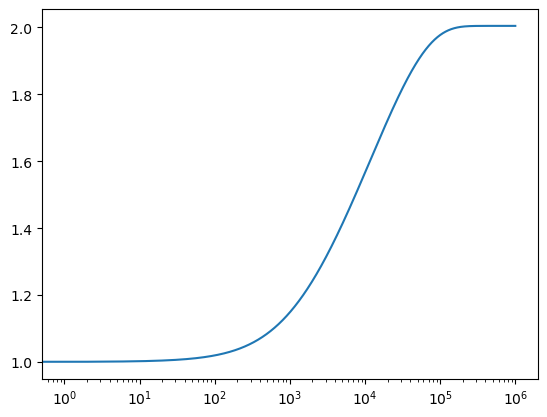

In [40]:
plt.plot(avg_sigma2)
plt.xscale('log')

In [ ]:
L = 4
N = 64
r = torch.Tensor((2*np.random.rand(N,2) - 1.0)*L)
sigma = torch.Tensor(np.repeat(np.eye(2)[None,:,:], N, axis=0)).requires_grad_(True)
optimizer = optim.SGD([sigma], lr=0.001, momentum=0, dampening=0, weight_decay=0, nesterov=False)
for step in range(100):
    det_S = torch.linalg.det(sigma)
    inv_S = torch.linalg.inv(sigma)
    C_2 = torch.sqrt(det_S)*sqrt(2*torch.pi)/4
    energy = inv_S*det_S

In [ ]:
C_2

In [ ]:
@njit
def compute_gradients(r, sigma, indices, K_tilde, g_tilde, alpha):
    N = r.shape[0]
    determinants = np.zeros(N)
    for i in range(N):
        determinants[i] =  np.linalg.det(sigma[i])
    sigma_gradients = np.zeros_like(sigma)
    for i in range(N):
        sigma_inv_i = np.linalg.inv(sigma[i,:,:]) 
        sigma_gradients[i,:,:] = K_tilde*np.sqrt(determinants[i])*(0.5*np.trace(sigma_inv_i)*sigma_inv_i - sigma_inv_i @ sigma_inv_i)
        sigma_gradients[i,:,:] += g_tilde*0.5*np.sqrt(determinants[i])*sigma_inv_i
        for j in indices[i,:]:
            if(i == j):
                continue
            dr = r[i,:]  - r[j,:] 
            outer_dr = dr[:,None]*dr[None:]
            sum_sigmas = sigma[i,:,:] + sigma[j,:,:]
            sum_sigmas_inv_ij = np.linalg.inv(sum_sigmas)
            determinants_ratio_ij = determinants[i]*determinants[j]/np.linalg.det(sum_sigmas)
            overlap = np.exp(-0.5*(dr @ sum_sigmas_inv_ij @ dr) + 0.5*np.log(determinants_ratio_ij))
            sigma_gradients[i,:,:] -= 0.5*alpha*overlap*( sum_sigmas_inv_ij @ outer_dr @ sum_sigmas_inv_ij + sum_sigmas_inv_ij - sigma_inv_i )/len((indices)-1)
    return sigma_gradients

In [ ]:
dt = 0.001
N = 256
L = 4

for step in range(5000):
    tree = KDTree(r)
    distances, indices = tree.query(r, 10)
    grads = compute_gradients(r, sigma, indices, 0.0, -0.1, 2.0)
    sigma -= dt*grads
    if(step % 100 == 0):
        print(np.sqrt(np.linalg.det(sigma)).mean())

In [ ]:
plt.hist(np.sqrt(np.linalg.det(sigma)),bins=20)

In [ ]:
fig, ax = plt.subplots()
for i in range(N):
    vals, vecs = np.linalg.eigh(sigma[i])
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    # Width and height are "full lengths" of the axes
    width, height = np.sqrt(vals)/2
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))  # angle of major axis

    ellipse = Ellipse(xy=r[i,:], width=width, height=height, angle=angle, linewidth=0.1, edgecolor='black', facecolor='white')
    ax.add_patch(ellipse)
plt.scatter(r[:,0], r[:,1], color='black', s=1)
ax.set_aspect('equal')
plt.show()